In [86]:
import math
import numpy as np
import scipy.optimize as opt
from rouwen import rouwen
from numba import jit
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# DSGE

In [2]:
# Parameters
gamma = 2.5
xi = 1.5
beta = 0.98
alpha = 0.40
a = 0.5
delta = 0.10
z_bar = 0
tau = 0.05

## Problem 5

In [3]:
def euler_eqns(x, *args):
    gamma, beta, alpha, delta, z_bar, tau = args
    k = x[0]
    l = 1
    r = alpha*((l*np.exp(z_bar)/k)**(1-alpha))
    w = (1-alpha)*np.exp(z_bar)*((k/np.exp(z_bar))**alpha)
    c = w*l+(r-delta)*k
    euler = 1/(c**gamma)-(beta/(c**gamma))*((1-tau)*(r-delta)+1)
    return euler

x_init = 5
args = gamma, beta, alpha, delta, z_bar, tau
k = opt.fsolve(euler_eqns,x_init,args=args)
y = k**alpha*(np.exp(z_bar)**(1-alpha))
i = delta*k
print('K:', k, 'Y:', y, 'I:', i)

K: [ 7.28749795] Y: [ 2.21325461] I: [ 0.7287498]


## Problem 6

In [4]:
def euler_eqns_2(x, *args):
    gamma, xi, beta, alpha, a, delta, z_bar, tau = args
    k = x[0]
    l = x[1]
    r = alpha*((l*np.exp(z_bar)/k)**(1-alpha))
    w = (1-alpha)*np.exp(z_bar)*((k/(l*np.exp(z_bar)))**alpha)
    c = w*l+(r-delta)*k
    euler = np.zeros(2)
    euler[0] = (c**(-gamma))-beta*(c**(-gamma))*((1-tau)*(r-delta)+1)
    euler[1] = w*(1-tau)*(c**(-gamma))-a*((1-l)**(-xi))
    return euler

x_init2 = np.array([4,0.5])
args2 = gamma, xi, beta, alpha, a, delta, z_bar, tau
ans = opt.fsolve(euler_eqns_2,x_init2,args=args2)
k = ans[0]
l = ans[1]
y = (k**alpha)*(((np.exp(z_bar)*l)**(1-alpha)))
i = delta*k
print('K:', k, 'L:', l, 'Y:', y, 'I:', i)

K: 4.22522902678 L: 0.579791453167 Y: 1.28322610883 I: 0.422522902678


## Problem 8

In [40]:
# Parameters
alpha = 0.35
beta = 0.98
rho = 0.95
sigma = 0.02
num = 26

In [71]:
# Create discrete grid for k
A = alpha*beta
kbar = A**(1/(1-alpha))
kmax = 1.5*kbar
kmin = 0.5*kbar
kgrid = np.linspace(kmin,kmax,num)

# Create grid for z 
zmax = 5*sigma
zmin = -5*sigma
mu = (zmax+zmin)/2
step = (zmax-zmin)/(num-1)
pi, zgrid = rouwen(rho,mu,step,num)

# Initialize value and policy functions
sizek = num
sizez = num
V = np.zeros((sizek,sizez))
Vmat = np.zeros((sizek,sizek,sizez))

In [76]:
@jit
def VFI_loop(V,beta,alpha,sizek,sizez,Vmat,pi,zgrid,kgrid):
    for i in range(sizek):  # loop over k
        for j in range(sizek):  # loop over k'
            for k in range(sizez): #loop over z
                expected_sum = np.dot(V[j,:],pi[:,k]) # find expected value given z
                Vmat[i,j,k] = (np.log(np.exp(zgrid[k])*(kgrid[i]**alpha)-kgrid[j]) + 
                                beta * expected_sum)
    return Vmat

def value_iteration(V,Vmat,sizek,sizez,pi,kgrid,zgrid,tol=1e-08,maxiter=1000):
    error = 100
    iteration = 0
    while error > tol and iteration < maxiter:
        TV = np.copy(V)
        Vmat = VFI_loop(V,beta,alpha,sizek,sizez,Vmat,pi,zgrid,kgrid)
        H = np.zeros((sizek,sizez),dtype=int)
        V = Vmat.max(axis=1) # apply max operator to Vmat (to get V(k))
        H = np.argmax(Vmat, axis=1) # find the index of the optimal k'
        error = (np.absolute(V - TV)).max()  # check distance between value
        # function for this iteration and value function from past iteration
        iteration += 1
    if iteration < maxiter:
        print('Value function converged after this many iterations:', iteration)
    else:
        print('Value function did not converge')
    return V, H

In [77]:
VF, HF = value_iteration(V,Vmat,sizek,sizez,pi,kgrid,zgrid)

opt_K = np.zeros((sizek,sizez))

for k in range(sizez):
    opt_K[:,k] = kgrid[HF[:,k]]

Value function converged after this many iterations: 913


<IPython.core.display.Javascript object>


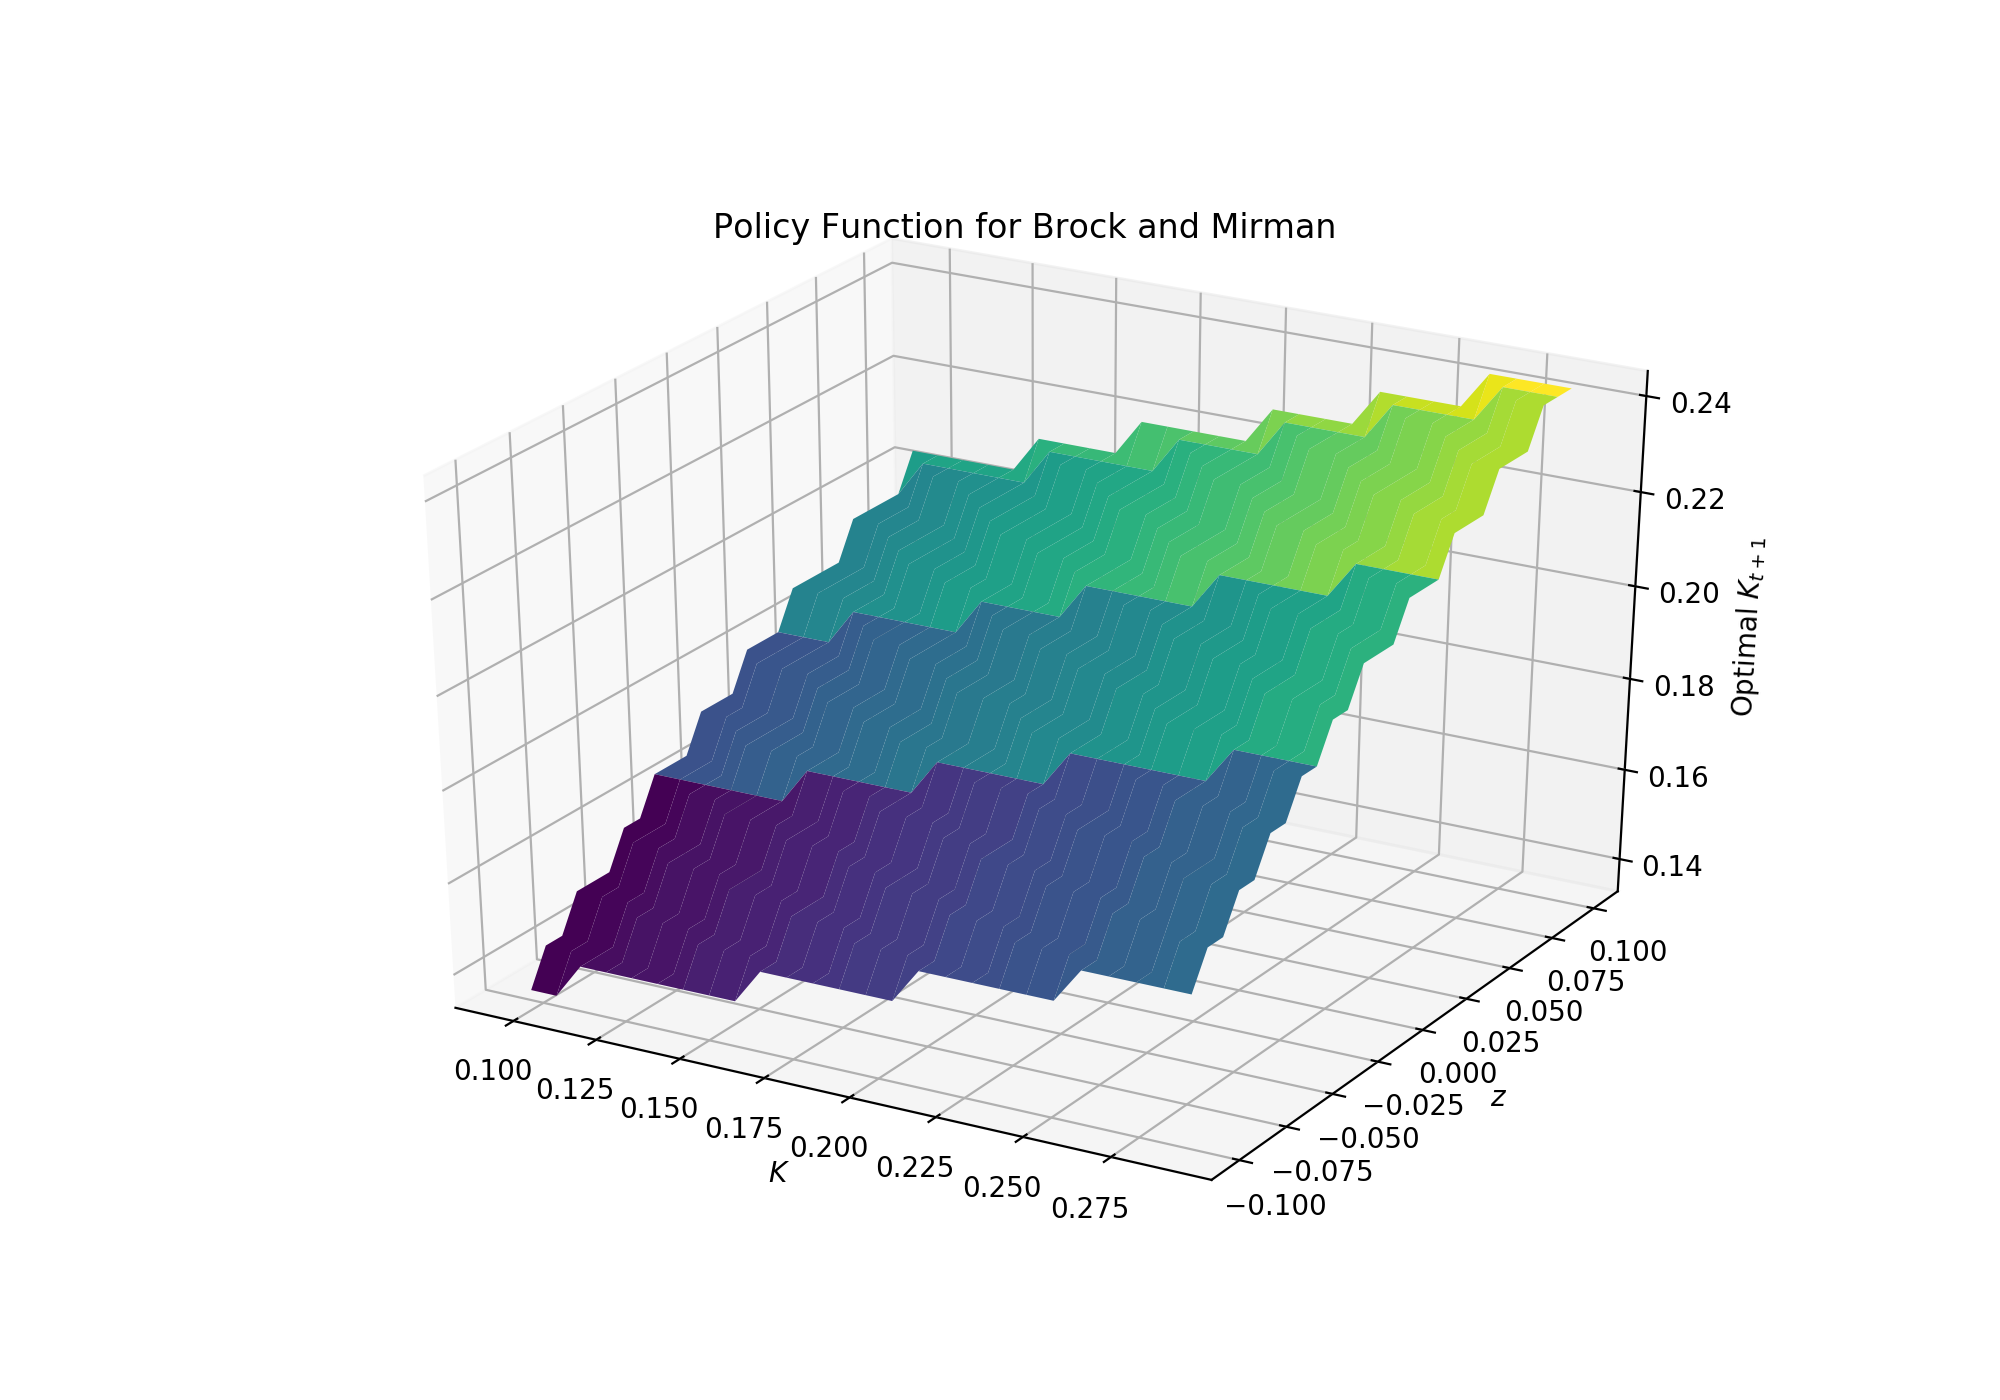

In [85]:
# Plot optimal capital stock rule as a function of firm size
kmat, zmat = np.meshgrid(kgrid,zgrid)
fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')
ax.plot_surface(kmat, zmat, opt_K, rstride=8,
                cstride=1, cmap='viridis')
ax.set_title('Policy Function for Brock and Mirman')
ax.set_xlabel(r'$K$')
ax.set_ylabel(r'$z$')
ax.set_zlabel(r'Optimal $K_{t+1}$')
plt.savefig('Brock_and_Merman_policy.jpg')
plt.show()

<IPython.core.display.Javascript object>


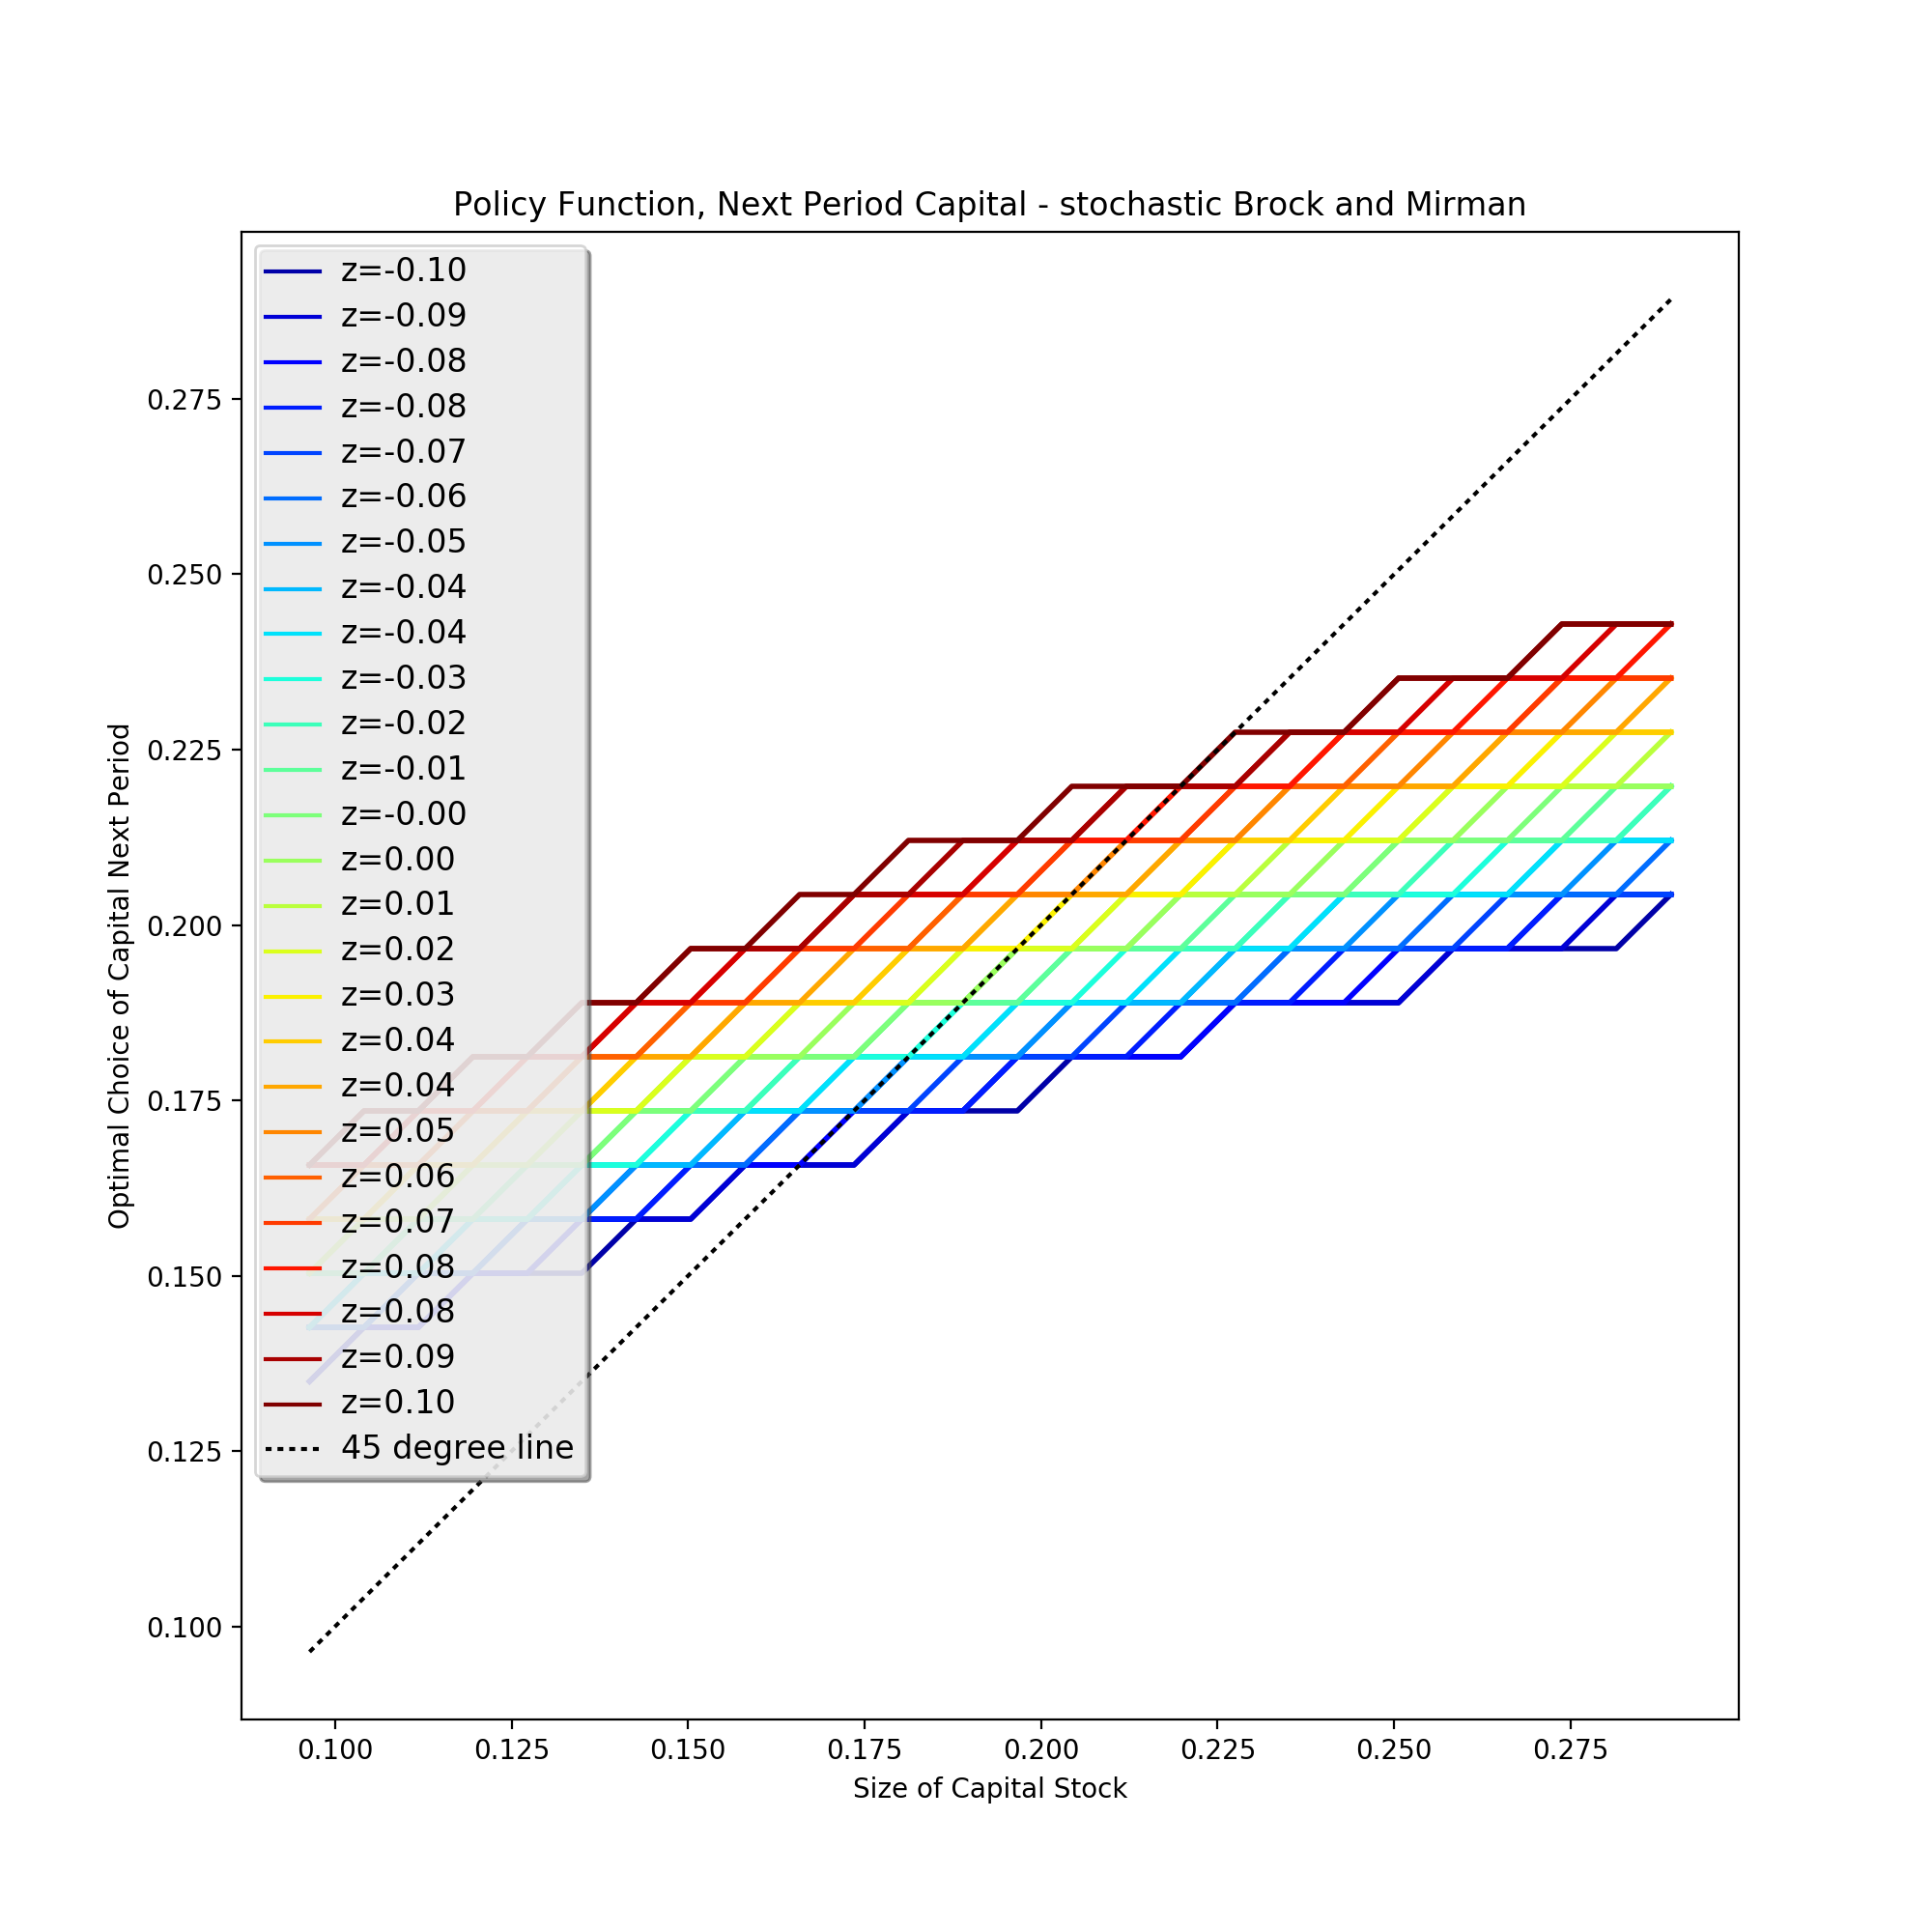

In [79]:
# Plot optimal capital stock rule as a function of firm size
fig, ax = plt.subplots(figsize=(10,10))
for k in range(sizez):
    lb = 'z='+format(zgrid[k],'.2f')
    ax.plot(kgrid, opt_K[:,k], color=plt.cm.jet((k+1)/sizez),lw=2,label=lb)
ax.plot(kgrid, kgrid, 'k:', label='45 degree line')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
#frame = legend.get_frame()
#frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Choice of Capital Next Period')
plt.title('Policy Function, Next Period Capital - stochastic Brock and Mirman')
plt.show()